# Versión 1

Celda 1 – Imports y verificación de GPU 

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from PIL import Image

print("Versión de PyTorch:", torch.__version__)
print("¿CUDA disponible?:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Versión de PyTorch: 2.9.1+cu130
¿CUDA disponible?: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


device(type='cuda')

Celda 2 – Descargar y descomprimir dataset de Kaggle 

In [11]:
import shutil

# Crear carpeta .kaggle si no existe
# os.makedirs(os.path.expanduser('C:\Users\julyp\.kaggle'), exist_ok=True)

# Mover kaggle.json al directorio correcto
#shutil.copy("kaggle.json", os.path.expanduser('C:/Users/julyp/.kaggle/kaggle.json'))

# Dar permisos
os.chmod(os.path.expanduser('C:/Users/julyp/.kaggle/kaggle.json'), 600)


In [ ]:
# Descargar dataset de la competencia Dogs vs Cats
!kaggle competitions download -c dogs-vs-cats --force



  0%|          | 0.00/812M [00:00<?, ?B/s]
 11%|█▏        | 93.0M/812M [00:00<00:00, 966MB/s]
 24%|██▍       | 195M/812M [00:00<00:00, 1.02GB/s]
 36%|███▌      | 293M/812M [00:00<00:00, 1.02GB/s]
 48%|████▊     | 391M/812M [00:00<00:00, 598MB/s] 
 61%|██████    | 492M/812M [00:00<00:00, 711MB/s]
 72%|███████▏  | 582M/812M [00:00<00:00, 771MB/s]
 84%|████████▎ | 680M/812M [00:00<00:00, 838MB/s]
 95%|█████████▍| 769M/812M [00:01<00:00, 763MB/s]
100%|██████████| 812M/812M [00:01<00:00, 793MB/s]
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Celda 3 – Crear estructura de carpetas y train/validation split

In [ ]:
print("Creando estructura de carpetas...")

BASE_DIR = 'data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')

TRAIN_CATS_DIR = os.path.join(TRAIN_DIR, 'cats')
TRAIN_DOGS_DIR = os.path.join(TRAIN_DIR, 'dogs')
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, 'cats')
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, 'dogs')

# limpiar si ya existía
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

os.makedirs(TRAIN_CATS_DIR, exist_ok=True)
os.makedirs(TRAIN_DOGS_DIR, exist_ok=True)
os.makedirs(VALIDATION_CATS_DIR, exist_ok=True)
os.makedirs(VALIDATION_DOGS_DIR, exist_ok=True)

# Directorio original con las imágenes del dataset (train/)
original_train_dir = 'train'

all_filenames = os.listdir(original_train_dir)
cat_filenames = [f for f in all_filenames if f.startswith('cat')]
dog_filenames = [f for f in all_filenames if f.startswith('dog')]

print("Total gatos en train original:", len(cat_filenames))
print("Total perros en train original:", len(dog_filenames))

# Subconjunto: 5000 gatos y 5000 perros (puedes cambiar este número)
cat_filenames = cat_filenames[:5000]
dog_filenames = dog_filenames[:5000]

# 80% train / 20% validation
train_cats, val_cats = train_test_split(cat_filenames, test_size=0.2, random_state=42)
train_dogs, val_dogs = train_test_split(dog_filenames, test_size=0.2, random_state=42)

def copy_files(filenames, source_dir, destination_dir):
    for f in filenames:
        src = os.path.join(source_dir, f)
        dst = os.path.join(destination_dir, f)
        shutil.copyfile(src, dst)

print("Copiando archivos...")

copy_files(train_cats, original_train_dir, TRAIN_CATS_DIR)
copy_files(train_dogs, original_train_dir, TRAIN_DOGS_DIR)
copy_files(val_cats, original_train_dir, VALIDATION_CATS_DIR)
copy_files(val_dogs, original_train_dir, VALIDATION_DOGS_DIR)

print("\n¡Estructura de datos lista!")
print(f"Total imágenes de entrenamiento (gatos): {len(os.listdir(TRAIN_CATS_DIR))}")
print(f"Total imágenes de entrenamiento (perros): {len(os.listdir(TRAIN_DOGS_DIR))}")
print(f"Total imágenes de validación (gatos): {len(os.listdir(VALIDATION_CATS_DIR))}")
print(f"Total imágenes de validación (perros): {len(os.listdir(VALIDATION_DOGS_DIR))}")


Creando estructura de carpetas...
Total gatos en train original: 12500
Total perros en train original: 12500
Copiando archivos...

¡Estructura de datos lista!
Total imágenes de entrenamiento (gatos): 4000
Total imágenes de entrenamiento (perros): 4000
Total imágenes de validación (gatos): 1000
Total imágenes de validación (perros): 1000


Celda 4 – Transforms y DataLoaders (train / validation) 

In [3]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Transforms: redimensionar + convertir a tensor (0-1)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    # Puedes agregar augmentations ligeros aquí si quieres:
    # transforms.RandomHorizontalFlip(),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

# Datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=VALIDATION_DIR, transform=val_transforms)

# DataLoaders
if __name__ == "__main__":
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

print("Clases:", class_names)
print("Índices de clases:", class_to_idx)
print("Total imágenes train:", len(train_dataset))
print("Total imágenes val:", len(val_dataset))


Clases: ['cats', 'dogs']
Índices de clases: {'cats': 0, 'dogs': 1}
Total imágenes train: 8000
Total imágenes val: 2000


Celda 5 – Definir la CNN en PyTorch

In [4]:
class CNNPerrosGatos(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Después de 3 bloques conv+pool con input 150x150:
        # 150 -> 75 -> 37 -> 18 (aprox, por el floor)
        # Canales: 3 -> 32 -> 64 -> 128
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)  # salida escalar (logit)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 75, 75]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 37, 37]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 18, 18]
        x = torch.flatten(x, 1)               # [B, 128*18*18]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                       # NO sigmoid aquí
        return x

model = CNNPerrosGatos().to(device)
print(model)


CNNPerrosGatos(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


Celda 6 – Definir loss y optimizador

In [ ]:
# Usamos BCEWithLogitsLoss porque la salida es un logit 
criterion = nn.BCEWithLogitsLoss()

# Optimizador Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Celda 7 – Loop de entrenamiento + validación

In [ ]:
EPOCHS = 30

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    ############################
    #      ENTRENAMIENTO       #
    ############################
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  
        
        optimizer.zero_grad()
        
        outputs = model(inputs)           # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        # Predicciones 
        preds = torch.sigmoid(outputs)
        preds = (preds >= 0.5).float()
        
        running_corrects += torch.sum(preds == labels).item()
        total_train += labels.size(0)
    
    epoch_train_loss = running_loss / total_train
    epoch_train_acc = running_corrects / total_train
    
    ############################
    #      VALIDACIÓN          #
    ############################
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            
            preds = torch.sigmoid(outputs)
            preds = (preds >= 0.5).float()
            
            val_running_corrects += torch.sum(preds == labels).item()
            total_val += labels.size(0)
    
    epoch_val_loss = val_running_loss / total_val
    epoch_val_acc = val_running_corrects / total_val
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"- Train loss: {epoch_train_loss:.4f}, acc: {epoch_train_acc:.4f} "
          f"- Val loss: {epoch_val_loss:.4f}, acc: {epoch_val_acc:.4f}")
    
print("¡Entrenamiento completado!")


Epoch 1/30 - Train loss: 0.6695, acc: 0.5725 - Val loss: 0.6194, acc: 0.6595
Epoch 2/30 - Train loss: 0.6009, acc: 0.6765 - Val loss: 0.5757, acc: 0.6975
Epoch 3/30 - Train loss: 0.5611, acc: 0.7127 - Val loss: 0.5579, acc: 0.7180
Epoch 4/30 - Train loss: 0.5239, acc: 0.7415 - Val loss: 0.5118, acc: 0.7575
Epoch 5/30 - Train loss: 0.4985, acc: 0.7538 - Val loss: 0.4984, acc: 0.7605
Epoch 6/30 - Train loss: 0.4653, acc: 0.7839 - Val loss: 0.4859, acc: 0.7740
Epoch 7/30 - Train loss: 0.4432, acc: 0.7916 - Val loss: 0.4828, acc: 0.7730
Epoch 8/30 - Train loss: 0.4238, acc: 0.8019 - Val loss: 0.4858, acc: 0.7590
Epoch 9/30 - Train loss: 0.3981, acc: 0.8209 - Val loss: 0.4668, acc: 0.7870
Epoch 10/30 - Train loss: 0.3832, acc: 0.8274 - Val loss: 0.4623, acc: 0.7870
Epoch 11/30 - Train loss: 0.3603, acc: 0.8373 - Val loss: 0.4530, acc: 0.7950
Epoch 12/30 - Train loss: 0.3471, acc: 0.8479 - Val loss: 0.4626, acc: 0.7865
Epoch 13/30 - Train loss: 0.3177, acc: 0.8654 - Val loss: 0.4489, acc: 0.

Celda 8 – Curvas de entrenamiento (accuracy y loss)

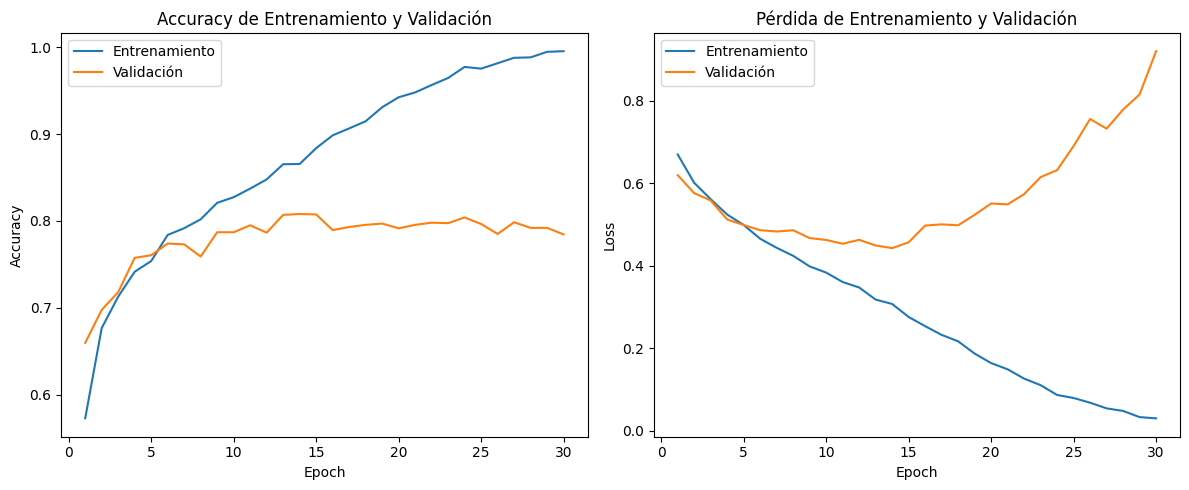

In [7]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Entrenamiento')
plt.plot(epochs_range, val_accuracies, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Validación')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Entrenamiento')
plt.plot(epochs_range, val_losses, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()


Celda 9 – Test de 100 imágenes nuevas + matriz de confusión

Gatos no usados: 7500
Perros no usados: 7500
Matriz de confusión (filas = verdaderas, columnas = predichas):
[[39 11]
 [ 6 44]]

Reporte de clasificación:
              precision    recall  f1-score   support

    Gato (0)       0.87      0.78      0.82        50
   Perro (1)       0.80      0.88      0.84        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



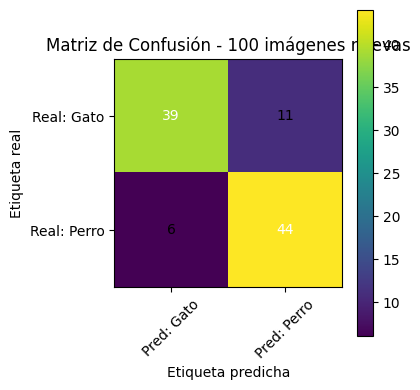

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader

# Identificar imágenes no usadas antes 

original_train_dir = 'train'

# Todas las imágenes originales
all_filenames = os.listdir(original_train_dir)
cat_all = [f for f in all_filenames if f.startswith('cat')]
dog_all = [f for f in all_filenames if f.startswith('dog')]

# Archivos que ya usamos en train/validation (nombres solamente)
used_filenames = set()

used_filenames.update(os.listdir(TRAIN_CATS_DIR))
used_filenames.update(os.listdir(TRAIN_DOGS_DIR))
used_filenames.update(os.listdir(VALIDATION_CATS_DIR))
used_filenames.update(os.listdir(VALIDATION_DOGS_DIR))

# Filtrar los que no se usaron
cat_unused = [f for f in cat_all if f not in used_filenames]
dog_unused = [f for f in dog_all if f not in used_filenames]

print("Gatos no usados:", len(cat_unused))
print("Perros no usados:", len(dog_unused))

# Tomamos 50 y 50 
num_per_class = 50
test_cat_files = cat_unused[:num_per_class]
test_dog_files = dog_unused[:num_per_class]

test_files = test_cat_files + test_dog_files
test_labels = [0] * len(test_cat_files) + [1] * len(test_dog_files)  # 0 = gato, 1 = perro


# Dataset para estos 100 ejemplos 

class DogsCatsFilesDataset(Dataset):
    def __init__(self, file_list, labels, root_dir, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        fname = self.file_list[idx]
        label = self.labels[idx]
        
        img_path = os.path.join(self.root_dir, fname)
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Usamos los mismos transforms de validación
test_transform = val_transforms

test_dataset = DogsCatsFilesDataset(
    file_list=test_files,
    labels=test_labels,
    root_dir=original_train_dir,
    transform=test_transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Evaluar modelo en estas 100 imágenes 

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)  
        
        outputs = model(inputs)            
        probs = torch.sigmoid(outputs)     
        preds = (probs >= 0.5).float()     
        
        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(labels.cpu().numpy().ravel())

all_preds = np.array(all_preds, dtype=int)
all_true = np.array(all_true, dtype=int)

# Matriz de confusión y reporte 

cm = confusion_matrix(all_true, all_preds)
print("Matriz de confusión (filas = verdaderas, columnas = predichas):")
print(cm)

print("\nReporte de clasificación:")
print(classification_report(all_true, all_preds, target_names=['Gato (0)', 'Perro (1)']))

# Visualizar matriz de confusión como heatmap 

plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusión - 100 imágenes nuevas")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Pred: Gato', 'Pred: Perro'], rotation=45)
plt.yticks(tick_marks, ['Real: Gato', 'Real: Perro'])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.show()


🧩 Celda 10 – Función para predecir una imagen externa

In [ ]:
def predecir_imagen(ruta_imagen):
    """
    Carga una imagen desde ruta_imagen, la preprocesa y la clasifica
    como gato o perro usando el modelo entrenado.
    """
    model.eval()
    
    # Abrir imagen
    img = Image.open(ruta_imagen).convert('RGB')
    
    # Aplicar mismo transform que validación
    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor()
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)  # (1, 3, H, W)
    
    with torch.no_grad():
        output = model(img_tensor)         # logit
        prob = torch.sigmoid(output)[0][0].item()
    
    # Interpretación
    if prob >= 0.5:
        label = "PERRO"
        confidence = prob * 100
    else:
        label = "GATO"
        confidence = (1 - prob) * 100
    
    # Mostrar imagen
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicción: {label} ({confidence:.2f}%)")
    plt.show()
    
    print(f"Puntuación sigmoid: {prob:.4f}")
    print(f"El modelo predice: {label} con {confidence:.2f}% de confianza.")


# Ejemplo de uso (cuando tengas una imagen):
# predecir_imagen("ruta/a/mi_imagen.jpg")


🧩 Celda 11 – Guardar el modelo

In [9]:
model_filename = "clasificador_perros_gatos_v1_pytorch.pth"
torch.save(model.state_dict(), model_filename)
print(f"Modelo guardado como: {model_filename}")

Modelo guardado como: clasificador_perros_gatos_v1_pytorch.pth
